In [2]:
import numpy as np
from scipy import sparse 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
import networkx as nx
import random
import pandas as pd
from datetime import date, timedelta
from collections import Counter
import time
from tqdm import tqdm
import pickle
random.seed(42)

In [3]:
with open("../data/graph/edges.M.pkl", "rb") as f:
    edge_holder = pickle.load(f)

In [4]:
edges = edge_holder["edges"]
edges, len(edges)

(array([[122306, 126785,  15006],
        [ 95108, 126785,  15006],
        [ 95108, 122306,  15006],
        ...,
        [ 30651,  65273,  19119],
        [ 30651,  90807,  19119],
        [ 30651,  35865,  19119]]),
 12730596)

In [5]:
degree_count = {}

for v1, v2, _ in edges:
    degree_count[v1] = degree_count.get(v1, 0) + 1
    degree_count[v2] = degree_count.get(v2, 0) + 1

# Analysis

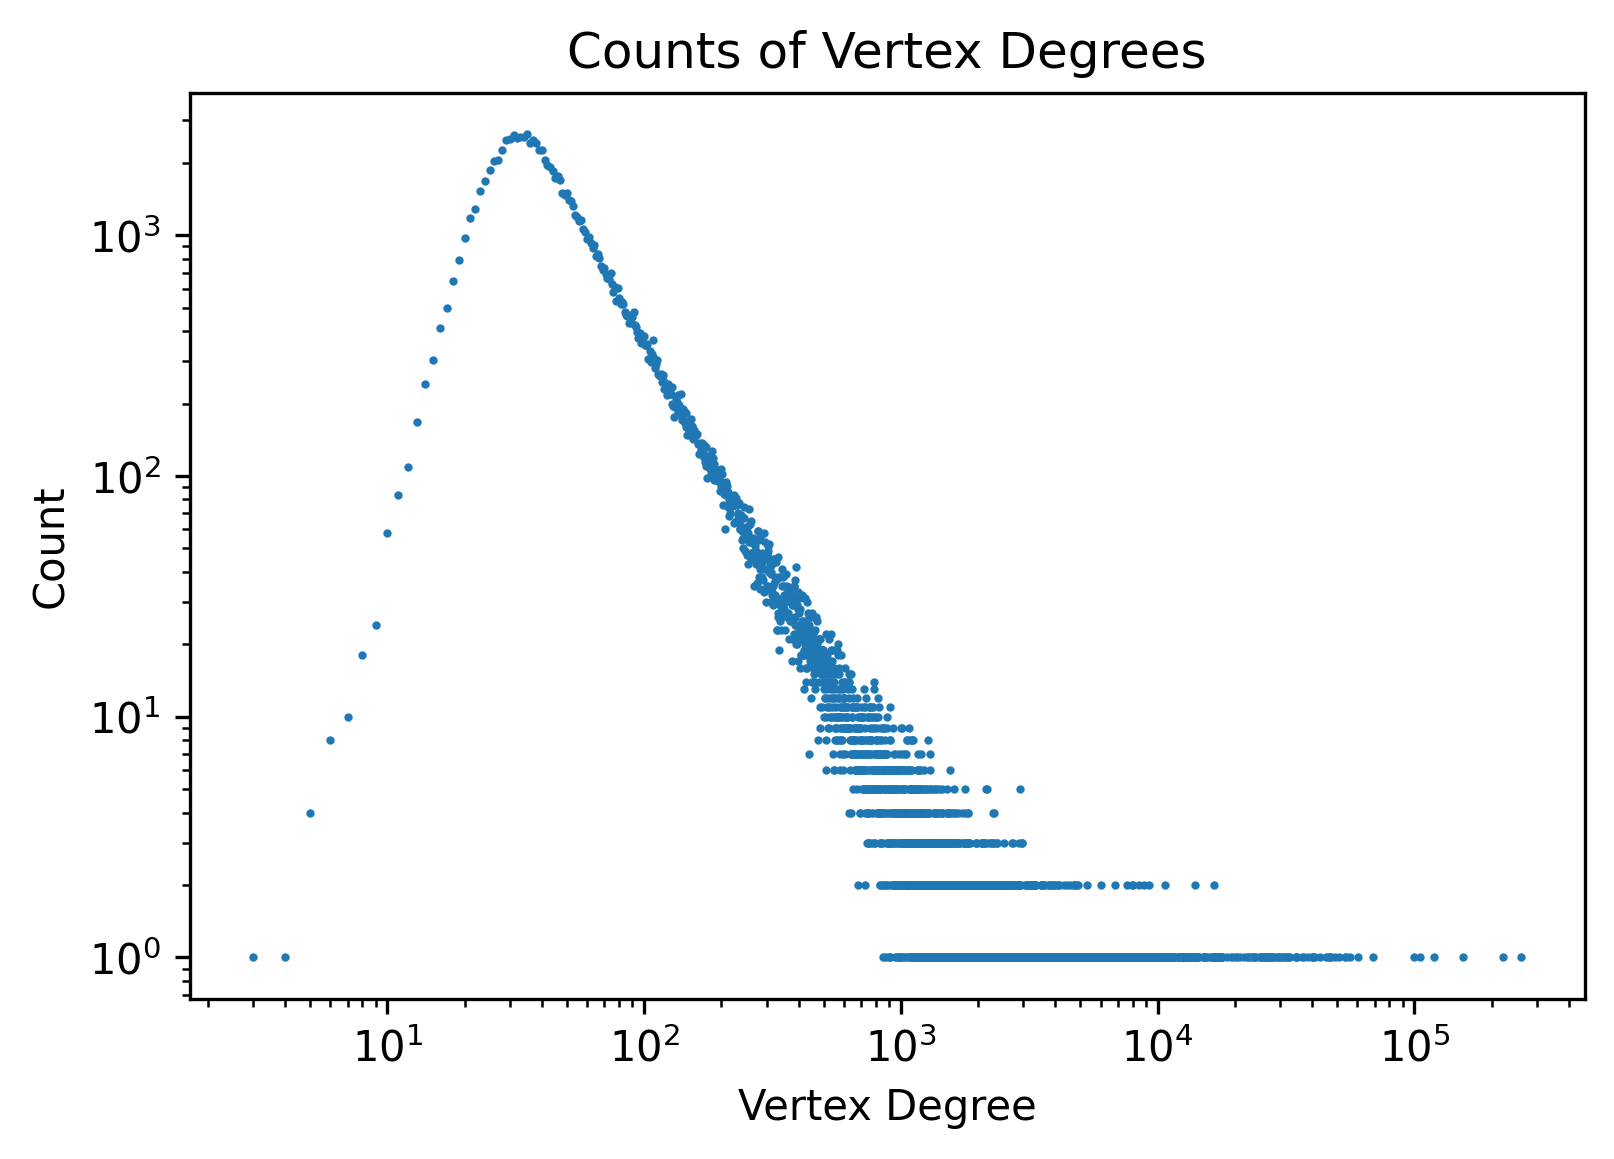

In [ ]:
data = Counter(degree_count.values())

x, y = zip(*data.items())
fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
plt.xscale("log")
plt.yscale("log")
plt.title('Counts of Vertex Degrees')
plt.xlabel('Vertex Degree')
plt.ylabel('Count')
plt.show()

In [ ]:
origin = date(1970, 1, 1)
years = [(origin + timedelta(days=int(days))).year for _, _, days in edges]

In [ ]:
def build_adj_matrix(edge_list):
    """Build a symmetric adjacency matrix from edge list."""
    EDGE_WEIGHT = np.ones(len(edge_list) * 2)  # each connection weights the same

    row_ind = np.concatenate((edge_list[:, 0], edge_list[:, 1]))
    col_ind = np.concatenate((edge_list[:, 1], edge_list[:, 0]))

    return sparse.csr_matrix(
        (
            EDGE_WEIGHT,
            (row_ind, col_ind),
        ),
        dtype=int
    )

ADJ_MAT = build_adj_matrix(edges)

G = nx.from_scipy_sparse_array(
    ADJ_MAT,
    parallel_edges=False,
)

# Concepts

Filter: 
- Occurence >= 3
- Words >= 3

Element-specific:
- No single elements (i.e. Na)
- No duplicates (i.e. IIINV, CH3COONa, Ga2O3Gd2O3)

In [ ]:
lookup = pd.read_csv("../data/table/lookup/lookup.M.2.csv")

def transform(vs):
    return [lookup.loc[index]["concept"] for index in vs]

pd.set_option('display.max_columns', None) # no ... in listing
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
lookup.sort_values('count', ascending=False)[["concept", "count"]].head(50)

# Vertices

In [ ]:
sorted_pairs = sorted(degree_count.items(), key=lambda x: x[1], reverse=True)
[(transform([vertex])[0],count) for vertex,count in sorted_pairs][:50]

In [ ]:
import pandas as pd

df = pd.read_csv("../data/table/materials-science.cleaned.works.csv")